# SQI Clustering using K-Means

The K-Means algorithm clusters data by trying to separate samples in n groups of equal
variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares.
This algorithm requires the number of clusters to be specified. It scales
well to large number of samples and has been used across a large range of application
areas in many different fields.

## 1. SQI calculation
courtesy of https://meta00.github.io/vital_sqi/_examples/others/plot_pipeline_02.html

In [1]:
# Libraries
# Generic
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scipy
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import entropy

# Scikit-learn
from sklearn.cluster import KMeans

# 3D projection
from mpl_toolkits.mplot3d import Axes3D

# Heartpy
import heartpy as hp

# Plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# vitalSQI
from vital_sqi.data.signal_io import ECG_reader
from vital_sqi.data.signal_io import PPG_reader
from vital_sqi.dataset import load_ppg, load_ecg

TERMINAL = True

# Data path
filepath = 'D:/IC Final Year Project/OUCRU/adults/01NVa-003-2001/PPG'
filename = '01NVa-003-2001 Smartcare.csv'

# Load patient data
signals = pd.read_csv(os.path.join(filepath, filename),
                      nrows=200000)

# Calculate sampling rate
fs = 1 / (signals.TIMESTAMP_MS.diff().median() * 0.001)

# Datetime start
start_datetime = '2021-01-01 17:00:00'

# Format the data

# Display (shows timedelta aligned)
pd.Timedelta.__str__ = lambda x: x._repr_base('all')

# Include column with index
signals = signals.reset_index()

signals['timedelta'] = \
    pd.to_timedelta(signals.TIMESTAMP_MS, unit='ms')

# Create datetimes (if needed)
signals['date'] = pd.to_datetime(start_datetime)
signals['date'] += pd.to_timedelta(signals.timedelta)

# Set the timedelta index (keep numeric index too)
signals = signals.set_index('timedelta')

# Rename column index to avoid confusion
signals = signals.rename(columns={'index': 'idx'})

# Create figure
# fig = go.Figure(go.Scatter(
#     x=signals.date,
#     y=signals.IR_ADC,
#     name='IR_ADC'))
# fig.update_xaxes(rangeslider_visible=True)
# fig.show() # Uncomment if running locally

# Trim first/last 5 minutes
# Offset
offset = pd.Timedelta(minutes=5)

# Indexes
idxs = (signals.index > offset) & \
       (signals.index < signals.index[-1] - offset)

# Filter
signals = signals[idxs]

def bbpf_rep(s):
    """Butter Band Pass Filter Scipy

    This is equivalent to the BandPassFilter() class implemented
    in the vital_sqi package. Need to understand the difference
    between filtfilt and lfilter.

    There is no need to compute the nyquist frequency. We can
    just pass the frequency sample and scipy will adjust the
    cutoff frequencies according to the nyquist theorem:

                f = f / 0.5*fs

    Note that scipy has also a bandpass filter (btype=band) but
    it is not possible to choose different orders for the high
    pass and low pass filters.
    """
    from scipy import signal
    # Configure high/low filters
    bh, ah = signal.butter(1, 1, fs=fs, btype='high', analog=False)
    bl, al = signal.butter(4, 20, fs=fs, btype='low', analog=False)
    # Apply filters
    aux = signal.filtfilt(bh, ah, s)
    aux = signal.lfilter(bl, al, aux)
    # Return
    return aux


# Add vital signals
signals['PLETH_BPF'] = bbpf_rep(signals.PLETH)

# Show
# print("\nSignals (all):")
# signals
#
# if TERMINAL:
#     print(signals)

# Compute SQIs
import vital_sqi.sqi as sq


def snr(x, axis=0, ddof=0):
    """Signal to noise ratio"""
    a = np.asanyarray(x)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m / sd)


def zcr(x):
    """Zero crossing rate"""
    return 0.5 * np.mean(np.abs(np.diff(np.sign(x))))


def mcr(x):
    """Mean crossing rate"""
    return zcr(x - np.mean(x))


def perfusion(x, y):
    """Perfusion

    Parameters
    ----------
    x: raw signal
    y: filtered signal
    """
    return (np.max(y) - np.min(y)) / np.abs(np.mean(x)) * 100


def correlogram(x):
    """Correlogram"""
    return sq.rpeaks_sqi.correlogram_sqi(x)


def msq(x):
    """Mean signal quality (is this the acronym?)

    Feedback for the package:
      The msq_sqi should also allow to receive two peak detector
      ids as input parameters. At the moment only allows a list
      of peaks and a peak detector id.
    """
    # Library
    from vital_sqi.common.rpeak_detection import PeakDetector
    # Detection of peaks
    detector = PeakDetector()
    peak_list, trough_list = detector.ppg_detector(x, 7)
    # Return
    return sq.standard_sqi.msq_sqi(x, peaks_1=peak_list, peak_detect2=6)


def dtw(x):
    """Dynamic time warping

    .. note: It is very slow!!

    Returns
    -------
    [mean, std]
    """
    # Library
    from vital_sqi.common.rpeak_detection import PeakDetector
    # Detection of peaks
    detector = PeakDetector()
    peak_list, trough_list = detector.ppg_detector(x, 7)
    # Per beats
    dtw_list = sq.standard_sqi.per_beat_sqi( \
        sqi_func=sq.dtw_sqi, troughs=trough_list,
        signal=x, taper=True, template_type=1
    )
    # Return mean
    return [np.mean(dtw_list),
            np.std(dtw_list)]


def sqi_all(x):
    """Compute all SQIs.

    .. note: If some variables are required for different
             SQIS (e.g. detecting the peaks), it might be
             possible to save some time by computing them
             first instead of having each method to compute
             them within the method. There is a trade off
             between the efficiency gained (depends on the
             implementation of the PeakDetector) and the
             the simplicity of the code and usage.
    """
    # Information
    dinfo = {
        'first': x.idx.iloc[0],
        'last': x.idx.iloc[-1],
        'skew': skew(x['PLETH']),
        'kurtosis': kurtosis(x['PLETH']),
        'snr': snr(x['PLETH']),
        'mcr': mcr(x['PLETH']),
        'zcr': zcr(x['PLETH_BPF']),
        'msq': msq(x['PLETH_BPF']),
        'perfusion': perfusion(x['PLETH'], x['PLETH_BPF']),
        'correlogram': correlogram(x['PLETH_BPF']),
        # 'dtw': dtw(x['0_bbpf'])
    }

    # Return
    return pd.Series(dinfo)

# 1. use the method 'agg'
# Group by 30s windows/aggregate
sqis = signals \
    .groupby(pd.Grouper(freq='30s')) \
    .agg({'idx': ['first', 'last'],
          'PLETH': [skew, kurtosis, snr, mcr],
          'IR_ADC': [skew, kurtosis, snr, mcr],
          'PLETH_BPF': [zcr, msq, correlogram]  # dtw]
          })

# .. note: We are assuming that the whole signal has been
#          read in one chunk. This will not work if using
#          batches, will window ids be necessary?
# Add window id (if needed)
sqis['w'] = np.arange(sqis.shape[0])

# Show
# print("\nSQIs (agg):")
# sqis
#
# if TERMINAL:
#     print(sqis)

# 2. use 'apply' to compare
# Group by 30s windows/apply
sqis2 = signals \
    .groupby(pd.Grouper(freq='30s')) \
    .apply(sqi_all)

# Show
# print("\nSQIs (apply):")
# sqis2
#
# if TERMINAL:
#     print(sqis2)

print('Data points used for clustering: sqis.PLETH')
print(sqis.PLETH)

d:\python3\fyp2021venv\lib\site-packages\statsmodels-0.12.2-py3.7-win-amd64.egg\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


Data points used for clustering: sqis.PLETH
                            skew  kurtosis       snr       mcr
timedelta                                                     
0 days 00:05:00.010000  0.017485 -1.062043  2.167699  0.026676
0 days 00:05:30.010000 -0.128448 -1.069134  2.047278  0.027009
0 days 00:06:00.010000 -0.141570 -1.106822  1.985901  0.026676
0 days 00:06:30.010000  0.090379 -1.036433  1.938730  0.026676
0 days 00:07:00.010000 -0.056560 -1.121963  1.943096  0.027009
0 days 00:07:30.010000 -0.088541 -0.901183  2.067898  0.027009
0 days 00:08:00.010000 -0.125679 -0.892545  2.146677  0.027009
0 days 00:08:30.010000  0.005239 -1.108326  1.882688  0.026676
0 days 00:09:00.010000 -0.019300 -1.039623  2.118613  0.025675
0 days 00:09:30.010000 -0.020004 -1.113730  1.989773  0.026676
0 days 00:10:00.010000 -0.020216 -1.129955  1.929146  0.026009
0 days 00:10:30.010000 -0.009143 -1.161163  1.876142  0.026676
0 days 00:11:00.010000  0.031969 -0.872736  2.170920  0.026342
0 days 00:1

## 2. K-Means clustering

### 2.1. Data points from sqis.PLETH (10 clusters, 4 features)
SQIs: skew, kurtosis, snr, mcr

In [2]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, n_init=100).fit(sqis.PLETH)
print('K-Means labels with number of clusters = ', n_clusters)
print(kmeans.labels_)

K-Means labels with number of clusters =  10
[6 0 0 3 4 5 9 4 6 4 4 4 2 4 4 3 3 3 9 2 4 0 5 0 0 0 4 7 4 0 2 0 8 5 0 3 0
 8 0 0 0 5 1 9 4 5 4]


### 2.2. Data points from sqis.PLETH (2 clusters, 4 features)
SQIs: skew, kurtosis, snr, mcr

Only one data point is categorised different from others.

In [3]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, n_init=100).fit(sqis.PLETH)
print('K-Means labels with number of clusters = ', n_clusters)
print(kmeans.labels_)

K-Means labels with number of clusters =  2
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0]


### 2.3. Data points from a subset of sqis.PLETH (3 clusters, 3 features)
SQIs: skew, kurtosis, snr

Note that the 3 clusters may represent 3 groups of Excellent, Acceptable, and Unfit.
(2.6.2 of Omar Muttawa's manuscript)

K-Means labels with number of clusters =  3
[1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 1 2 1 0 1 0]


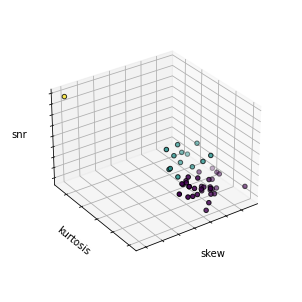

In [4]:
sqis_datapoints = sqis.PLETH[["skew", "kurtosis", "snr"]]

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, n_init=100).fit(sqis_datapoints)
print('K-Means labels with number of clusters = ', n_clusters)
print(kmeans.labels_)

fig = plt.figure()
ax = Axes3D(fig, elev=30, azim=235)
ax.scatter(sqis_datapoints["skew"], sqis_datapoints["kurtosis"], sqis_datapoints["snr"],
               c=kmeans.labels_.astype(float), edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('skew')
ax.set_ylabel('kurtosis')
ax.set_zlabel('snr')
ax.dist = 12.5

### 2.4. Data points from a subset of sqis.PLETH (2 clusters, 3 features)
SQIs: skew, kurtosis, snr

One outlier is salient in the plot.

K-Means labels with number of clusters =  2
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0]


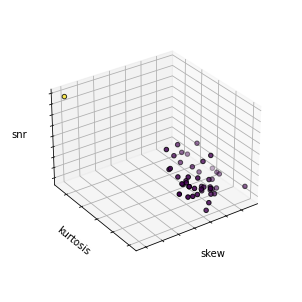

In [5]:
sqis_datapoints = sqis.PLETH[["skew", "kurtosis", "snr"]]

n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, n_init=100).fit(sqis_datapoints)
print('K-Means labels with number of clusters = ', n_clusters)
print(kmeans.labels_)

fig = plt.figure()
ax = Axes3D(fig, elev=30, azim=235)
ax.scatter(sqis_datapoints["skew"], sqis_datapoints["kurtosis"], sqis_datapoints["snr"],
               c=kmeans.labels_.astype(float), edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('skew')
ax.set_ylabel('kurtosis')
ax.set_zlabel('snr')
ax.dist = 12.5

Elbow Method - Measures the Sum of Squared distance from data points to
associated centroid. This value decreases as k increases.
